In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt

org_heats_dir = "/home/lyuze/workspace/obj_heats"
interested_file = "matmul_list.txt"
org_heats_file = os.path.join(org_heats_dir, interested_file)

In [23]:
columns = ["timestamp", "addr", "type", "cur_size", "diff"]
org_df = pd.read_csv(org_heats_file, sep="\t", header=None, names=columns)
org_df['addr'] = org_df['addr'].apply(lambda x: int(x, 16)) # convert address to decimal

In [24]:
print(org_df['timestamp'].dtype)
print(org_df['addr'].dtype)
print(org_df['type'].dtype)
print(org_df['cur_size'].dtype)
print(org_df['diff'].dtype)

float64
int64
object
int64
float64


In [25]:
# 1. get all *live* unique objects per sampling period
def get_unqiue_obj(df):
    unique_objs_num = df['addr'].nunique()
    print("# unique objects:", unique_objs_num)
    grouped_orgdf = df.groupby('timestamp')
    total_obj_size_sample = []
    unique_objs_sample = [] # list to store all *live* objects thru exec
    ts_gap = []
    prev_ts = 0
    for ts, group_df in grouped_orgdf:
        cur_totol_size_mb = round(group_df['cur_size'].sum() / (1024*1024), 2)
        total_obj_size_sample.append(cur_totol_size_mb)
        unique_objs_sample.append(group_df['addr'].nunique())
        ts_gap.append(ts - prev_ts)
        prev_ts = ts
    ts_gap.pop(0) # delete the 1st elem in ts_gap
    avg_sample_dur = round(sum(ts_gap) / len(ts_gap), 2) # get the average of sample duration
    print("avg_sample_dur: ", avg_sample_dur)
    return unique_objs_sample, avg_sample_dur, total_obj_size_sample

# unique objects: 177130
avg_sample_dur:  0.17
[18819, 21840, 23374, 24907, 20340, 26448, 27996, 29559, 31127, 34285, 35879, 32704, 37476, 39077, 40693, 42311, 43952, 47256, 48927, 50586, 52255, 53938, 45587, 55632, 59036, 60747, 62473, 57336, 64213, 65968, 67727, 71280, 73073, 74864, 76674, 78480, 69501, 80308, 82152, 84003, 85873, 87745, 89625, 91498, 93387, 95281, 97182, 99070, 100983, 102908, 104856, 106817, 108786, 110775, 112774, 114790, 116818, 118855, 120910, 122970, 127146, 125050, 129262, 131386, 133521, 137842, 135675, 140007, 142204, 144415, 148883, 146640, 151151, 153440, 155736, 158061, 160396, 162743, 165104, 167481, 169875, 172298, 174726, 57768]
[6.07, 6.22, 6.3, 6.37, 6.15, 6.45, 6.53, 6.6, 6.68, 6.84, 6.92, 6.76, 7.0, 7.08, 7.16, 7.24, 7.32, 7.48, 7.56, 7.65, 7.73, 7.81, 7.4, 7.9, 8.06, 8.15, 8.24, 7.98, 8.32, 8.41, 8.5, 8.67, 8.76, 8.85, 8.94, 9.03, 8.58, 9.12, 9.21, 9.3, 9.4, 9.49, 9.58, 9.67, 9.77, 9.86, 9.96, 10.05, 10.15, 10.24, 10.34, 10.43, 10.53, 10.63, 10.73

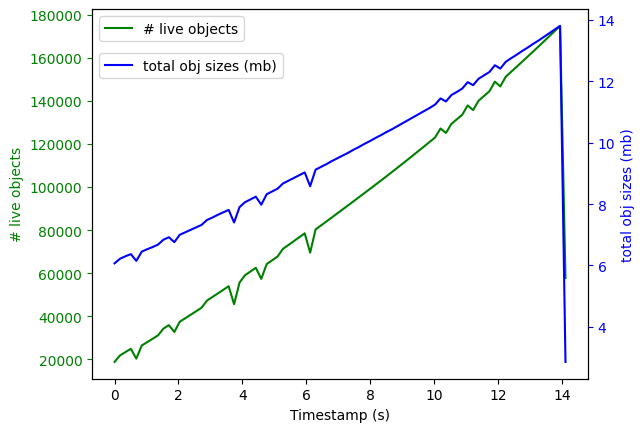

In [26]:
# 1.1 plot unique addresses VS time
y1, avg_sample_dur, y2 = get_unqiue_obj(org_df)
print(y1)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

# # plot single plot
# plt.plot(x_time, unique_objs_sample)
# plt.xlabel('Timestamp (s)')
# plt.ylabel('# Objects')
# plt.title('# of objects with time')
# plt.savefig("live_unique_objs.png")

# unique objects: 113979
avg_sample_dur:  0.17
[0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.08, 0.08, 0.07, 0.07, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.08, 0.08, 0.07, 0.08, 0.07, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.07, 0.08, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.08, 0.08, 0.07, 0.07, 0.07, 0.08, 0.07, 0.07, 0.07, 0.08, 0.07, 0.08, 0.08, 0.07, 0.08, 0.07, 0.07, 0.07, 0.07]


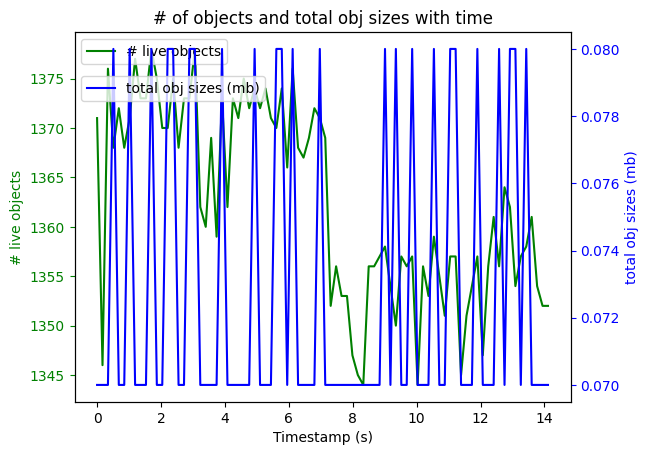

In [27]:
# 2. get all *active* unique objects 
filtered_df_no_zeros = org_df[(org_df["diff"] != 0)]
filtered_df_no_zeros_files = os.path.join(org_heats_dir, "matmul_list_no_zeros.txt")
filtered_df_no_zeros.to_csv(filtered_df_no_zeros_files, sep='\t', index=False, header=False)

y1, avg_sample_dur, y2 = get_unqiue_obj(filtered_df_no_zeros)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
plt.title('# of objects and total obj sizes with time')
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

# plt.plot(x_time, y1)
# plt.xlabel('Timestamp (s)')
# plt.ylabel('# Objects')
# plt.title('# of objects with time')
# plt.savefig("active_unique_objs.png")

# unique objects: 146
avg_sample_dur:  0.17
[8, 2, 3, 4, 3, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 1, 3, 4, 4, 2, 2, 1, 3, 4, 4, 3, 4, 4, 4, 3, 2, 4, 2, 4, 2, 4, 3, 2, 1, 3, 3, 4, 1, 1, 2, 1, 3, 3, 2, 2, 2, 3, 3, 3, 1, 1, 3, 4, 4, 1, 3, 5, 4, 2, 1, 4, 3, 3, 3, 1, 4, 3, 1, 3, 4, 4, 3, 3, 3, 3, 4, 2, 3, 1]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


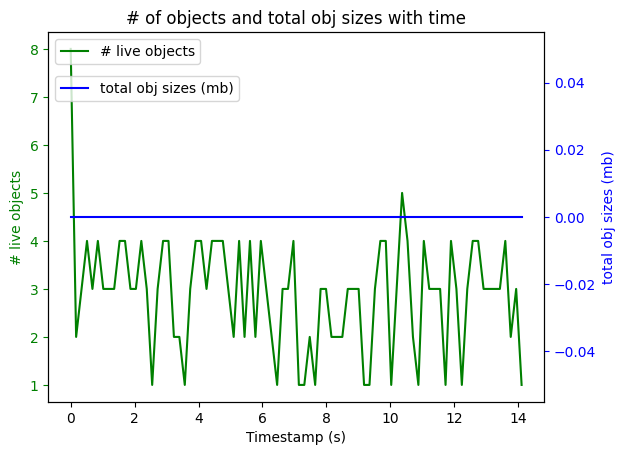

In [28]:
# filter out both 0 and 1 increment
filtered_df_no_zeros_ones = org_df[(org_df["diff"] != 0) & (org_df["diff"] != 1) & (org_df["diff"] != -1)]
filtered_df_no_zeros_ones_files = os.path.join(org_heats_dir, "matmul_list_no_zeros_ones.txt")
filtered_df_no_zeros_ones.to_csv(filtered_df_no_zeros_ones_files, sep='\t', index=False, header=False)

y1, avg_sample_dur, y2 = get_unqiue_obj(filtered_df_no_zeros_ones)
print(y1)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
plt.title('# of objects and total obj sizes with time')
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

Min addr: 140737324159152
Max addr: 140737352876912
address range: 27.4


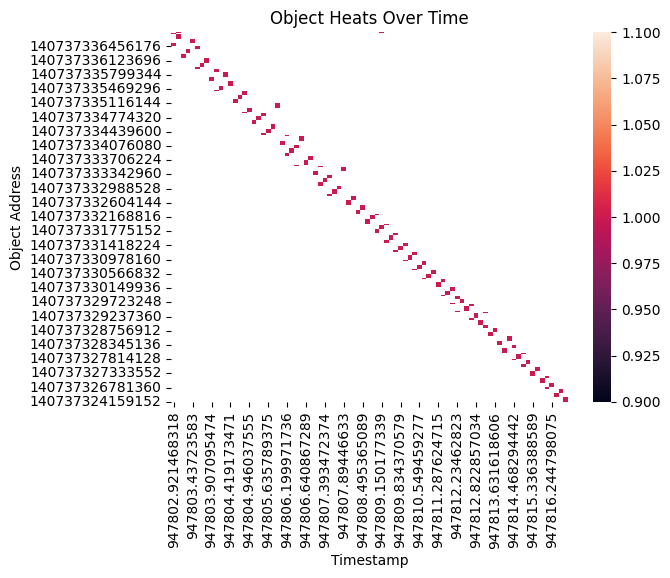

In [29]:
import pandas as pd
import seaborn
# import matplotlib.pyplot as plt|
data = {
    'timestamp': ['124.11', '124.11', '124.11', '124.12', '124.12', '124.12'],
    'addr': [1, 2, 100, 1, 2, 100],
    'diff': [0.1, 0.2, 0.3, -0.2, 0.3, 0.7]
}

columns = ["timestamp", "addr", "type", "cur_size", "diff"]
filtered_df_no_zeros_ones = pd.read_csv("/home/lyuze/workspace/obj_heats/matmul_list_no_zeros.txt", sep="\t", header=None, names=columns)
condition = filtered_df_no_zeros_ones['addr'].astype(str).str.startswith('93')
filtered_df_no_zeros_ones = filtered_df_no_zeros_ones[~condition]
filtered_df_no_zeros_ones['diff'] = filtered_df_no_zeros_ones['diff'].abs()
min_ = filtered_df_no_zeros_ones["addr"].min()
max_ = filtered_df_no_zeros_ones["addr"].max()
print("Min addr:", min_)
print("Max addr:", max_)
addr_range = (max_ - min_) / (1024*1024)
print("address range: {:.1f}".format(addr_range))

# df = pd.DataFrame(data)
heatmap_data = filtered_df_no_zeros_ones.pivot(index='addr', columns='timestamp', values='diff')
# plt.figure(figsize=(10, 6))  # Optional: set the figure size

# Customize the heatmap style and appearance as needed
# seaborn.set()  # Set Seaborn styling
seaborn.heatmap(heatmap_data, annot=False, cbar=True, robust=True)
#  cmap='YlGnBu'
plt.gca().invert_yaxis()
# Set labels and title
plt.xlabel("Timestamp")
plt.ylabel("Object Address")
plt.title("Object Heats Over Time")

# Show the heatmap
plt.show()
